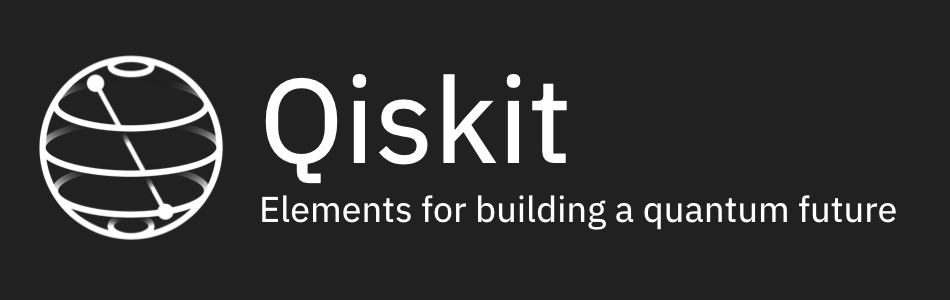

# Qiskit Aer: The Extended Stabilizer Simulator

## Introduction

The Extended Simulator is a new method for classically simulating quantum circuits available in the latest release of [Qiskit-Aer](https://github.com/qiskit/qiskit-aer). 

This method is an implementation of the ideas published in the paper _Simulation of quantum circuits by low-rank stabilizer decompositions_ by Bravyi, Browne, Calpin, Campbell, Gosset & Howard, 2018, [**arXiv:1808.00128**](https://arxiv.org/abs/1808.00128).

It uses a different representation of a quantum circuit, that gives it some unique capabilities. This notebook will give some examples of what the extended stabilizer method can do.

For example:

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.compiler import assemble
from qiskit.providers.aer import AerError, QasmSimulator
from qiskit.tools.visualization import plot_histogram

import random

In [2]:
circ = QuantumCircuit(40, 40)

# Initialise with a Hadamard layer
circ.h(range(40))
# Apply some random CNOT and T gates
qubit_indices = [i for i in range(40)]
for i in range(10):
    control, target, t = random.sample(qubit_indices, 3)
    circ.cx(control, target)
    circ.t(t)
circ.measure(range(40), range(40))

qobj = assemble(circ, backend=QasmSimulator(), shots=1)

We've created a random circuit with just 60 gates, that acts on 40 qubits. But, because of the number of qubits, if we wanted to run this with say the statevector simulator then I hope you have access to terabytes of RAM!

In [3]:
statevector_job = QasmSimulator().run(qobj, backend_options={
    'method': 'statevector'
})
# This should error!
try:
    statevector_job.result()
except AerError as err:
    print(err)

The Extended Stabilizer method, in contrast, handles this circuit just fine. (Though it needs a couple of minutes!)

In [4]:
es_job = QasmSimulator().run(qobj, backend_options={
    'method': 'extended_stabilizer'
})
result = es_job.result()
print('This succeeded?: {}'.format(result.success))

This succeeded?: True


## How does this work?
If you're interested in how exactly we can handle such large circuits, then for a detailed explanation you can [read the paper!](https://arxiv.org/abs/1808.00128)

For running circuits, however, it's important to just understand the basics.

The Extended Stabilizer method is made up of two parts. The first is a method of decomposing quantum circuits into _stabilizer circuits_, a special class of circuit that can be efficiently simulated classically. The second is then a way of combining these circuits to perform measurements.

The number of terms you need scales with the number of what we call _non-Clifford Gates_. At the moment, the method knows how to handle the following methods:
```python
circ.t(qr[qubit])
circ.tdg(qr[qubit])
circ.ccx(qr[control_1], qr[control_2], qr[target])
circ.u1(rotation_angle, qr[qubit])
```

The simulator is also able to handle circuits of up to 63 qubits.
     


One thing that's important to note is these decompositions are approximate. This means that the results aren't exactly the same as with the State Vector simulator.

In [5]:
small_qr = QuantumRegister(2)
small_cr = ClassicalRegister(2)
small_circ = QuantumCircuit(small_qr, small_cr)
small_circ.h(small_qr[0])
small_circ.cx(small_qr[0], small_qr[1])
small_circ.t(small_qr[0])
small_circ.measure(small_qr, small_cr)
small_qobj = assemble(small_circ, backend=QasmSimulator(), shots=100)
# This circuit should give 00 or 11 with equal probability...
expected_results ={'00': 50, '11': 50}

In [6]:
es_job = QasmSimulator().run(small_qobj, backend_options={'method':'extended_stabilizer'})
es_result = es_job.result()
es_counts = es_result.get_counts(small_circ)
print('100 shots in {}s'.format(es_result.time_taken))

100 shots in 3.9687795639038086s


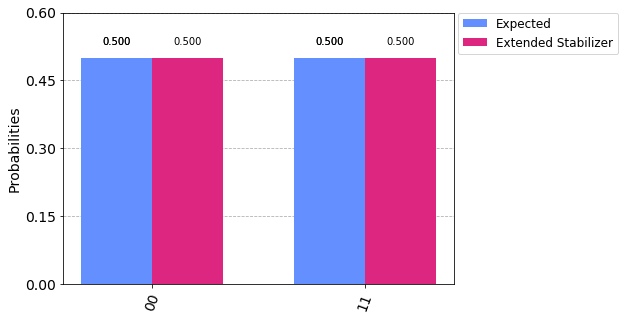

In [7]:
plot_histogram([expected_results, es_counts], legend=['Expected', 'Extended Stabilizer'])

You can control this approximation error using the `backend_options` in Qiskit Aer. The default error is 0.05. The smaller the error, the more precise the results, but also the longer your simulation will take and the more memory it will require.

100 shots in 10.484436273574829s


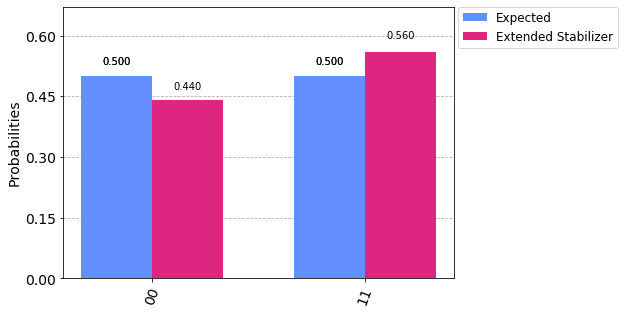

In [8]:
es_job = QasmSimulator().run(small_qobj, backend_options={
    'method':'extended_stabilizer',
    'extended_stabilizer_approximation_error': 0.03
})
es_result = es_job.result()
es_counts = es_result.get_counts(small_circ)
print('100 shots in {}s'.format(es_result.time_taken))
plot_histogram([expected_results, es_counts], legend=['Expected', 'Extended Stabilizer'])

## Simulator Options

There are several other options you can tweak to control how the extended stabilizer method performs. What these options are and their explanation can all be found in the Qiskit Aer documentation. However, I want to highlight two important ones that can help to optimize your simulations.

To perform measurements, the extended stabilizer method uses a Markov chain method to sample outcomes at random. This Markov chain has to be run for some time we call the 'mixing time' before it will start sampling, and has to be re-mixed for every circuit shot.

If you expect your circuit output to be concentrated on just a few output states, then you can likely optimize your simulations by reducing the `extended_stabilizer_mixing_time` option.



In [9]:
print("The circuit above, with 100 shots at precision 0.03 "
      "and default mixing time, needed {}s".format(int(es_result.time_taken)))
optimised_job = QasmSimulator().run(small_qobj, backend_options={
    'method': 'extended_stabilizer',
    'extended_stabilizer_approximation_error': 0.03,
    'extended_stabilizer_mixing_time': 100
})
optimised_result = optimised_job.result()
print('Dialing down the mixing time, we completed in just {}s'.format(optimised_result.time_taken))

The circuit above, with 100 shots at precision 0.03 and default mixing time, needed 10s
Dialing down the mixing time, we completed in just 0.26561832427978516s


Similarly, if your circuit has some non-zero probability on all amplitudes (e.g. if it's a random circuit), then you can avoid this expensive re-mixing step to take multiple shots from the output at once. This can be enabled by setting `extended_stabilizer_measure_sampling=True` in the `backend_options`.

For example, let's look again at the random circuit from the start of the tutorial, running for 100 shots:

In [10]:
multishot_qobj = assemble(circ, backend=QasmSimulator(), shots=100)

In [11]:
# It's a 40 qubit circuit so we use Extended Stabilizer automatically
multishot_job = QasmSimulator().run(multishot_qobj, backend_options={
    'extended_stabilizer_mixing_time': 100 # We set this here only to make the example run more quickly.
})
result = multishot_job.result()
print("100 shots took {} s".format(result.time_taken))

100 shots took 31.812614917755127 s


In [12]:
multishot_job = QasmSimulator().run(multishot_qobj, backend_options={
    'extended_stabilizer_measure_sampling': True,
    'extended_stabilizer_mixing_time': 100 # We set this here only to make the example run more quickly.
})
result = multishot_job.result()
print("With the optimization, 50 shots took {} s".format(result.time_taken))

With the optimization, 50 shots took 0.15625762939453125 s


## How can I use it?

In the latest release of Qiskit Aer, if you try to run a circuit on more qubits than can be handled by the state vector simulator, then Aer will automatically switch to using the extended stabilizer method. You can also force circuits to run on this method using the `backend_options` keyword argument to `QasmSimulator().run`. 

It's worth bearing in mind: if you have smaller circuits with lots of non-Clifford gates, then the statevector method will likely perform better than the extended stabilizer. If however you want to look at circuits on many qubits, without needing access to high performance computation, then give this method a try!

In [13]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright